In [521]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
from scipy.stats import multivariate_normal
import os
from matplotlib.pyplot import imread
np.random.seed(13579201)


(77760, 135)


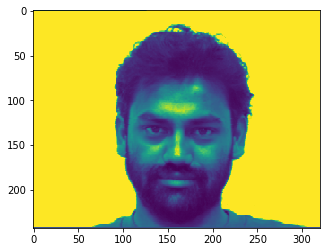

In [522]:
width = 320
height = 243
images = []
for file in os.listdir("./train"):
    if file.endswith(".pgm"):
        im = imread("./train/" + file)
        im = im.flatten('F') # flatten im into a vector|
        images.append(im) 
A_pp = np.stack(images).T # build a matrix where each column is a flattened image
print(A_pp.shape)
plt.imshow(A_pp[:, 134].reshape(width, height).T)
plt.show()

In [523]:
def det(A):
    det_A = 0
    A1 = A
    row = A.shape[0]
    column = A.shape[1]
    li = []
    
    if (row == 1):
        det_A = A[0,0]
    if (row == 2):
        det_A = A[0,0] * A[1,1] - A[0,1] * A[1,0]
    if(row > 2):
        for i in range(row):
            A1 = np.delete(A,0,axis = 0)
            A1 = np.delete(A1,i,axis = 1)
            det_A = det_A + ((-1) ** (i + 0) * A[0,i] * det(A1))
#                 li.append(temp)
#                 det_A = sum(li)
    return det_A

print(det(np.eye(2)))
# Y = np.arange(3,4).reshape(1,1)
# print(det(Y))
# X = np.arange(1,10).reshape(3,3)
# Z = np.array([[1,2,3],[3,1,2],[0,0,1]])
# print(det(Z))
# det(np.array([[2]]))

1.0


In [525]:
def preprocess(A_pp):
    # WRITE CODE HERE
    D = A_pp.shape[0]
    N = A_pp.shape[1]
    A = np.zeros((D,N))
    Q_norms = np.zeros(D)
    mu = np.zeros(D)
    for i in range(D):
        mu[i] = (1 / N) * (np.sum(A_pp[i],axis = 0))
        Q_i = A_pp[i] - mu[i]
        Q_norms[i] = np.max(abs(Q_i))
        if (Q_norms[i] == 0):
            A[i] = Q_i
        else:
            A[i] = Q_i / Q_norms[i]
            
    return A, Q_norms, mu

A, Q_norms, A_means = preprocess(A_pp)
print(A)
print(Q_norms)
print(A_means)
# A_pp


[[-0.05675839  0.08298111  0.08298111 ...  0.08298111  0.08298111
   0.08298111]
 [ 0.04695702  0.04695702  0.04695702 ...  0.04695702  0.04695702
   0.04695702]
 [ 0.02724746  0.03954982  0.03954982 ...  0.03954982  0.03954982
   0.03954982]
 ...
 [ 0.28539493  0.18479881  0.28539493 ...  0.24627422  0.28539493
   0.28539493]
 [ 0.29004113  0.17786364  0.29004113 ...  0.22273464  0.29004113
   0.29004113]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[ 85.87407407 156.64444444 162.57037037 ... 178.93333333 178.28888889
   0.        ]
[122.87407407 247.64444444 248.57037037 ... 203.93333333 203.28888889
  68.        ]


In [526]:
def eigen_faces(A_pp):
    # WRITE CODE HERE
    A, Q_norms, A_norms = preprocess(A_pp)
    E_values, E_vectors = np.linalg.eig(A.T@A)
    Eigenvector = np.real(E_vectors)
    F = A@Eigenvector
    D = np.zeros((len(E_values),len(E_values)))
    for i in range(len(E_values)):
        D[i][i] = E_values[i]
    for i in range(A_pp.shape[1]):
        F[:,i] = F[:,i] / np.linalg.norm(F[:,i])
    F = np.real(F)
    C = A.T@F
    return C, F, D, Q_norms, A_means

#For the purposes of doing this assignment, this code isn't really here. Pretend it's engraved in rock.
C, F, D, Q_norms, A_means = eigen_faces(A_pp)
F_real = np.real(F)
print('Orthogonality Check (should be close to 0): ', F_real[:, 0].T@F_real[:, 1])
print('Unit Vector Check: ', math.isclose(np.linalg.norm(F_real[:,0]), 1))
print(F.shape)
print(C.shape)
print(D.shape)


/Users/huangrunxiang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


Orthogonality Check (should be close to 0):  4.996003610813204e-16
Unit Vector Check:  True
(77760, 135)
(135, 135)
(135, 135)


359.14259133177313 -115.93204759007244


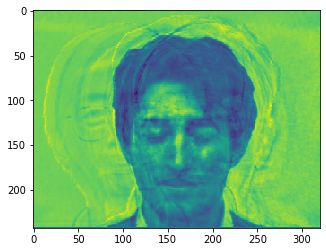

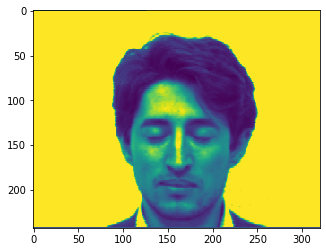

In [527]:
def reconstruct_image(Img, F, Q_norms, A_means):
    # WRITE CODE HERE
    R_vec = ((Img@F.T) * Q_norms) + A_means
    im = R_vec.reshape((243,320),order = "F")
#     print(Img.shape,F.shape)
    return im

#Display Code. Shoo! Away with you!
Idx = 133
Img = (A[:, Idx]).T@F
R = reconstruct_image(Img, F, Q_norms, A_means)
plt.imshow(R)
print(np.amax(R), np.amin(R))
plt.show()
R = A_pp[:, Idx].reshape(width, height).T
plt.imshow(R)
plt.show()
 

Variance Captured: 78 %
310.71118728067245 -31.241250333283034


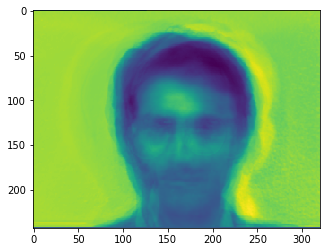

359.14259133177313 -115.93204759007244


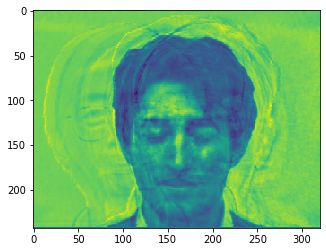

Error (expect around 2500000 for k = 10): 
 1918623.7409311756


In [540]:
def reduce_dimensionality(image_vector, k, F, D, A_means, Q_norms):
    # WRITE CODE HERE
    A = np.zeros(len(image_vector))
    F_1 = F.copy()
    F_1 = np.array(F_1)
    L = image_vector.shape[0]
    Q = np.zeros(A_means.shape)
    for i in range(L):
        Q[i] = image_vector[i] - A_means[i]
        if (Q_norms[i] == 0):
            A[i] = Q[i]
        else:
            A[i] = Q[i] / Q_norms[i]
    A = A.reshape((1,A.shape[0]))
    Trans_Img = (np.array(A))@F_1
    Img = Trans_Img.T
    compressed_image = []
    for i in range(k):
        compressed_image.append(Img[i,0])
    for i in range(F_1.shape[1] - k):
        compressed_image.append(0)
    
    
    p = sum(sum(D[0:k])) / sum(sum(D))
    return compressed_image, p

#Display Code. Leave it alooooooooooone.
#You can mess with settings, but return them to their original values.
compressed_image, p = reduce_dimensionality(A_pp[:, Idx], 10, F, D, A_means, Q_norms)
print('Variance Captured:', int(p * 100), '%')
R_c = reconstruct_image(compressed_image, F, Q_norms, A_means)
plt.imshow(R_c)
print(np.amax(R_c), np.amin(R_c))
plt.show()
R_o = reconstruct_image(Img, F, Q_norms, A_means)
plt.imshow(R_o)
print(np.amax(R_o), np.amin(R_o))
plt.show()
print('Error (expect around 2500000 for k = 10): \n', np.sum(np.abs(R_c - R_o)))

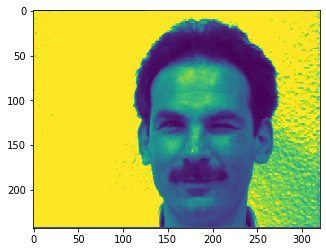

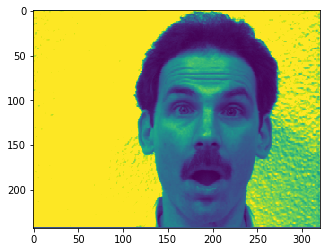

In [544]:
def the_nearest_image(image_vector, A_pp, k, F, D, A_means, Q_norms):
    # WRITE CODE HERE
    compressed_image, p = reduce_dimensionality(image_vector, k, F, D, A_means, Q_norms)
    R_c = reconstruct_image(compressed_image, F, Q_norms, A_means)
    min_in = 0    
    dv = []
    for i in range(A_pp.shape[1]):
        temp = A_pp[:,i]
        C_i, q = reduce_dimensionality(temp, k, F, D, A_means, Q_norms)
        R_t = reconstruct_image(C_i, F, Q_norms, A_means)
        dist = np.linalg.norm(R_c - R_t)
#         dist= np.sqrt(np.sum(np.square(R_c - R_t)))\
#         dist = np.sum(np.abs(R_c - R_t))
        dv.append(dist)

    mm = min(dv)
#     print(mm)
    for i in range(len(dv)):
        if dv[i]==mm:
            index = i
#     print(index)
    return index
# print(index)
im2 = imread("./test/subject02.wink.pgm")
# print(im2)
im2 = im2.T.flatten()
idx = the_nearest_image(im2, A_pp, 10, F, D, A_means, Q_norms)

plt.imshow(im2.reshape(width, height).T)
plt.show()
plt.imshow(A_pp[:, idx].reshape(width, height).T)
plt.show()